# Training a Generative Adversarial Network (GAN) on MNIST

This notebook implements and trains a **Generative Adversarial Network (GAN)**—a framework introduced by *Goodfellow et al., 2014*—with the goal of generating realistic handwritten digits from the MNIST dataset.

A GAN consists of two neural networks trained simultaneously in an adversarial setting:

- **Generator** \(G(z)\): maps a latent noise vector \(z \sim \mathcal{N}(0, I)\) to synthetic images.
- **Discriminator** \(D(x)\): outputs a probability that an input image \(x\) is real rather than generated.

The training follows the classical **minimax objective**:

$$\min_G \max_D \, \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log (1 - D(G(z)))]$$

In this notebook, we:

1. Load and normalize the MNIST dataset.
2. Implement a fully-connected Generator and Discriminator in PyTorch.
3. Train both networks through adversarial optimization.
4. Visualize generated samples to track model progression.

This provides a clean and instructive implementation of the foundational GAN framework.


In [71]:
import torch
from torch import nn 
import numpy as np 
import matplotlib.pyplot as plt 

# Generator 
class Generator(nn.Module):
    def __init__(self, noise_vector = 100):
        super(Generator, self).__init__()
        
        self.noise_vector = noise_vector
        
        self.generator = nn.Sequential(
            
                nn.ConvTranspose2d(in_channels = noise_vector, out_channels = 64, kernel_size = (4, 4), stride = (2, 2)),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2),
                
                nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = (4, 4), stride = (2, 2)),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2),
                
                nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (4, 4), stride = (2, 2)),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(0.2),
                
                nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (7, 7), padding = 1),
                nn.Tanh()
        )
        
    def forward(self, noise):
        return self.generator(noise)
    
    def unsqueze(self, noise):
        unsqueeze_noise = noise.view(len(noise), self.noise_vector, 1, 1) # 2D -> 4D
        return unsqueeze_noise

Noise Shape: torch.Size([4, 1, 26, 26])
Noise Shape: torch.Size([4, 26, 26])


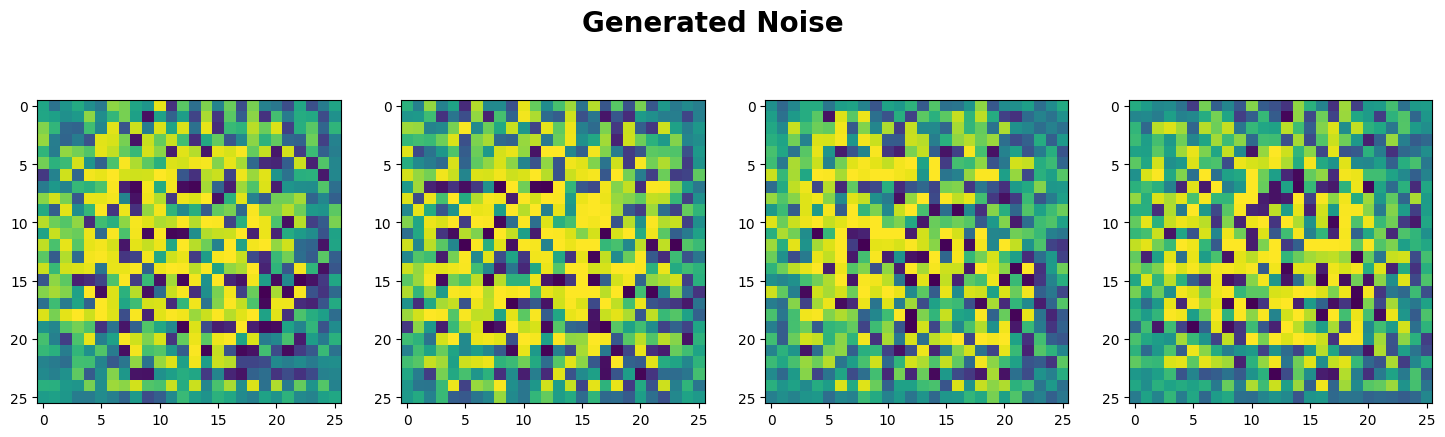

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator1 = Generator()

vector = torch.randn(4, 100).to(device = device)
unsqueze_vector = generator1.unsqueze(vector)
noises = generator1(unsqueze_vector)
print(f'Noise Shape: {noises.shape}')
noises_plot = noises[:, 0, :, :]
print(f'Noise Shape: {noises_plot.shape}')

num_img, height, weight = noises_plot.shape

fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (18, 5))
for i in range(num_img):
    img = noises_plot[i, :, :].reshape(height, weight)
    img = img.detach().numpy()
    axes[i].imshow(img)

plt.suptitle('Generated Noise', fontsize = 20, fontweight = 'bold')
plt.show()

In [73]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, n_channel = 1):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            
            nn.Conv2d(in_channels = n_channel, out_channels = 64, kernel_size = (3, 3), stride = (2, 2), padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (3, 3), stride = (2, 2), padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (3, 3), stride = (2, 2), padding = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = (3, 3), stride = (2, 2), padding = 0),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        return self.discriminator(img)
        

In [74]:
# import Data
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

transforms = transforms.Compose([
                                transforms.Resize(26),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5,), std = (0.5,))])

data = DataLoader(MNIST('.', download = False, transform = transforms), batch_size = 16, shuffle = True)

In [75]:
# Normalize Data - Avoiding vanishing gradient, gradients stabilization.
def Normalize(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0, 0.02)
        
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.constant_(m.bias, 0)
    
generator = Generator()
discriminator = Discriminator()

generator = generator.apply(Normalize)
discriminator = discriminator.apply(Normalize)

In [77]:
from tqdm.auto import tqdm
# loss
criterion = nn.BCELoss()

# optimizers 
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001)

# Initialize params
epochs = 8
batch_size = 16
latent_vector = 100

losses_generator = []
losses_discriminator = []

for epoch in range(epochs):
    
    total_discriminator_loss = 0
    total_generator_loss = 0
    batch_count = 0

    for real, label in tqdm(data, desc = f'Epoch: {epoch + 1}/{epochs}'):
        
        real = real.to(device)
        batch_count+= 1
        
        ### Discriminator###
        discriminator_optimizer.zero_grad()
        
        noise = torch.randn(batch_size, latent_vector).to(device)
        unsqueeze_vector = generator.unsqueze(noise)
        fake_img = generator(unsqueeze_vector)
        fake_predict = discriminator(fake_img.detach())
        fake_labels = torch.zeros_like(fake_predict)
        loss_fake_discriminator = criterion(fake_predict, fake_labels)
        
        real_predict = discriminator(real)
        real_label = torch.ones_like(real_predict)
        loss_real_discriminator = criterion(real_predict, real_label)
        mean_loss = (loss_fake_discriminator + loss_real_discriminator) / 2
        
        mean_loss.backward()
        discriminator_optimizer.step()
        
        total_discriminator_loss+= mean_loss.item()
        
        
        ### Generator###
        
        generator_optimizer.zero_grad()
        
        noise_gen = torch.randn(batch_size, latent_vector).to(device)
        unsqueze_vector_gen = generator.unsqueze(noise_gen)
        fake_image_gen = generator(unsqueze_vector_gen)
        fakes_img_gen = discriminator(fake_image_gen)
        fake_labels_gen = torch.ones_like(fakes_img_gen)
        loss_generator = criterion(fakes_img_gen, fake_labels_gen)
        
        loss_generator.backward()
        generator_optimizer.step()
        
        total_generator_loss += loss_generator.item()
        
    # Loss mean per epoch 
    epoch_discriminator_loss = total_discriminator_loss / batch_count
    epoch_generator_loss = total_generator_loss / batch_count

    # Keep losses 
    losses_discriminator.append(epoch_discriminator_loss)
    losses_generator.append(epoch_generator_loss)       

Epoch: 8/8: 100%|██████████| 3750/3750 [04:23<00:00, 14.25it/s]


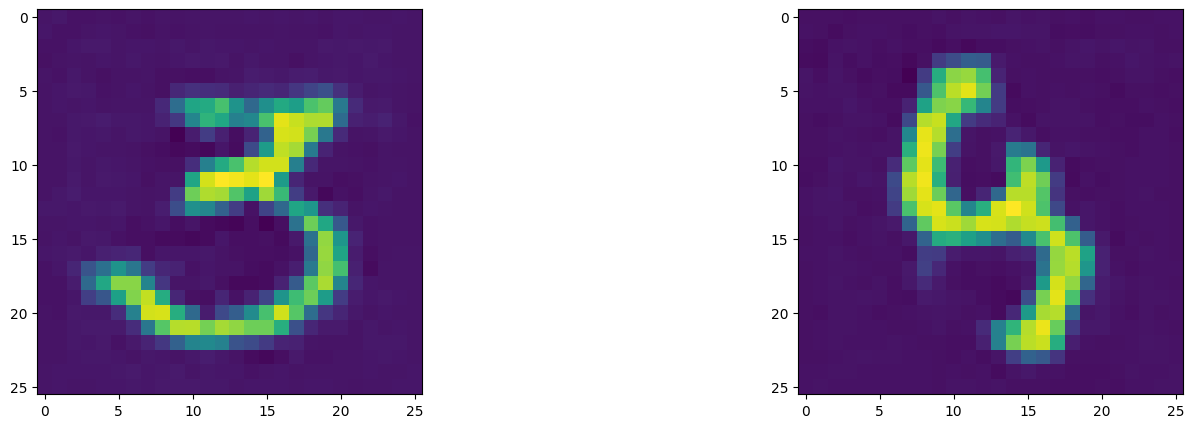

In [87]:
# Generation from random noise
noise_new = torch.randn(2, 100)
noise_new = generator.unsqueze(noise_new)
generate_images = generator(noise_new)

generate_images_final = generate_images[:, 0, :, :]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18, 5))
for i in range(len(generate_images_final)):
    img = generate_images_final[i].reshape(26, 26)
    img = img.detach().numpy()
    axes[i].imshow(img)
    
plt.show()